# Physics-based FENRIR GP for the Sun

FENRIR is a framework that allows to evaluate the likelihood of a Gaussian process modelling stellar activity. It can handle any combination of time-series of observations (photometry, radial velocities, spectroscopic indicators, flux at a certain wavelength...). The computational cost of a likelihood estimation scales linearly with the number of data points. FENRIR models come in two flavours: physics-based and data-driven. 

In this notebook, we analyze HARPN radial-velocities and SORCE photometry of the Sun with a physics-based FENRIR Gaussian Process (GP), following [Hara & Delisle (2025)](https://doi.org/10.48550/arXiv.2304.08489). The physics-based model stems from a quantitative physical model of the effect of spots and faculae on spectra and photometry. It is simply a Gaussian process model, but whose hyperparameters have a physical interpretation. In particular, this includes the stellar projected inclination. Thus, FENRIR can be used to retrieve information about the star through what we call statistical Doppler imaging: thanks to the average properties of the signal, we retrieve some properties of the star.

## FENRIR kernels

FENRIR kernels have the following form. Suppose we have $n$ observational channels. For instance if we have photometry and radial velocities $n=2$, and we label them respectively channel $1$ and $2$. For channels $i, j$ ($i$ = 1 or 2,  $j$ = 1 or 2), for a measurement taken in channel $j$, $\Delta t$ later than in channel $i$, the kernel has the following form
$$
k^{i,j}(\Delta t; \eta) = k^W(\Delta t; \eta_W) k^{per}_{i,j}(\Delta t; \eta_P) + k^\lambda(\Delta t; \eta_\lambda)  \; \; \; \; \; (1)
$$
Where $\eta$ is the vector of hyperparameters, which has three subsets detailed below. 
-  $k^W(\Delta t; \eta_W)$ is the part of the kernel corresponding to the intrinsic evolution of spots and faculae properties. Its hyperparameter $\eta_W$ are the average lifetime and size of spots and faculae. 
-  $k^{per}_{i,j}(\Delta t; \eta_P)$ is the part of the kernel corresponding to the stellar rotation. Its hyperparameter $\eta_P$ include the stellar rotation period (the star is assumed to have solid body rotation), the inclination of its rotation axis relative to the sky plane $\bar{i}$, and the typical latitudes of spots and faculae ($\delta$). The expression of $k^{per}_{i,j}(\Delta t; \eta_P)$ is truncated to a certain number of harmonics $n_\text{harm}$. 
-  $k^\lambda(\Delta t; \eta_\lambda)$ is the part of the kernel corresponding to the magnetic cycle. 

In practice we can express the kernel of our likelihood as a sum of two kernels: one corresponding to the spots, and one to the faculae. 
 
###  Model
The kernel and the physical model are linked in the following manner. 

The FENRIR model relies on several assumptions:

1. Features (spots and faculae) appear on the star according to a Poisson process, whose rate $\lambda(t)$ might vary with time
2. When a feature is such that it attains its maximal size at a time $t$, its properties $\gamma$ (size, lifetime, position) are drawn from a probability distribution $p(\gamma \mid \eta, t)$, where $\eta$ are the properties of the star (and the hyperparameters of the process, described above).
3. The effect of a feature of parameters $\gamma$ on channel $i$, attaining its maximal size at time $t_0$ is denoted by $g_i(t-t_0, \gamma)$. In Hara & Delisle (2025), we provide an analytical expression of functions $g$ on photometry and RV assuming pointwise features, taking into account the stellar surface darkening or brightening (spots and faculae, respectively), as well as the inhibition of convective blueshift, limb-darkening or limb-brightening effects. We show that $g_i(t, \gamma)$ can be put in the following form 
$$
g_i(t, \gamma)  = W(t,\gamma_W) P_i(t,\gamma_\mathrm{per}, \phi_0) $$ $$ P_i(t, \gamma_\mathrm{per}, \phi_0)  = \sum_{k=-d}^d i_k(\gamma_\mathrm{per}) \mathrm{e}^{\mathrm{i} k (\omega t + \phi_0)} 
$$
where $W_i(t,\gamma)$ is the evolution of the area times the brightness of the feature, and $P_i (t,\gamma)$ is a purely periodic component due to the changing projection of the feature as the star rotates. Note that $g_i(t, \gamma)$ can correspond to a single spot or facula, but can also correspond to the effect of a pattern of magnetic regions. We take advantage of that fact, and consider in the present example that $g_i(t, \gamma)$ is the effect of two magnetic regions at opposed longitudes (on a so-called active longitudes). The magnetic regions at the opposed longitudes have the same latitudes and lifetime, but their maximal size differs by a multiplicative factor which is a free parameter in our model. 

5. Channel $i$, denoted by $y_i(t)$ is assumed to be $ y_i(t) = \sum\limits_{k=-\infty}^{+\infty}  g_i(t-t_k, \gamma(t_k))$
6. The longitude at which a feature attains its maximal size follows a uniform law on $[0,2\pi]$
7. The transient, periodic and magnetic cycle part of the kernels do not share parameters, $W_i(t,\gamma) = W_i(t,\gamma_W)$, $P_i (t,\gamma) = P_i (t,\gamma_P)$, $k_\lambda(t,\gamma) = k_\lambda((t,\gamma_\lambda)$, and $\gamma_W, \gamma_P, \gamma_\lambda$ are statistically independent.
8. The transient part of the kernel $W_i(t,\gamma)$ is the same for all channels, that is all the feature has the same size in all channels.
9. The timescale of variation of $\lambda(t)$ is much greater than the stellar rotation period $2\pi/\omega$: the magnetic cycle has a timescale much longer than the stellar rotation period.

With all these hypotheses, we show that 
$$
k^{i,j}(\Delta t; \eta)  = \iint  g_i(t, \gamma)  g_j(t + \Delta t, \gamma)  p(\gamma\mid t, \eta)   \lambda(t) \mathrm{d} t  \mathrm{d} \gamma .
$$
This holds for assumptions 1-4. It simply means that the covariance of the process is the agerage autocorrelation of a single feature with itself. 
Furthermore, thanks to assumption 5-8, we have equation (1) above with 
with
$$
k^W(\Delta t; \eta_W)  = \iint  W_i(t, \gamma)  W_j(t + \Delta t, \gamma)  p(\gamma\mid t, \eta_W) \lambda(t)  \mathrm{d} t  \mathrm{d} \gamma \; \; \; \; \; (2)
$$
and
$$
k^P(\Delta t; \eta_P)  = \iint  P_i(t, \gamma)  P_j(t + \Delta t, \gamma)   p(\gamma\mid t, \eta_P) \lambda(t)  \mathrm{d} t  \mathrm{d} \gamma \; \; \; \; \; (3) 
$$
Both Eqs. (2) and (3) require to integrate the properties of individual magnetic regions $\gamma$ over the probability density $p(\gamma\mid t, \eta_P)$: that is the potential characteristics that a magnetic region can have when it appears. To simplify the expressions, we can assume that it is always the same pattern of magnetic regions that appears. In other words, every time a pattern of magnetic region appears, they have the same maximal size, latitude, lifetime, they simply appear at random times and random longitudes. This comes down to identifying the parameters $\eta$ and $\gamma$: we only try to estimate what are the characteristics of this average pattern of spots. Furthermore, we assume that $\lambda(t)$ is constant. Eqs. (3) and (4) become
$$
k^W(\Delta t; \eta_W)  = \lambda \int  W_i(t, \eta_W)  W_j(t + \Delta t, \eta_W) \mathrm{d} t \; \; \; \; \; (2 \text{ bis})
$$
and
$$
k^P(\Delta t; \eta_P)  =  \lambda \int  P_i(t, \eta_P)  P_j(t + \Delta t, \eta_P)    \mathrm{d} t  \; \; \; \; \; (3 \text{ bis}) 
$$

For Eq. (2), we can easily show that if $W(t)$ is a one-sided exponential (features appear suddenly, then have an exponential decay), $k^W(\Delta t; \eta_W)$ is simply a Matérn-1/2 kernel, and this is our assumption here. The term due to the magnetic cycle $k^\lambda$ is also assumed to be a Matérn-1/2 kernel. In Hara & Delisle (2025), we establish the expression of $P_i(t, \eta_P)$ for the magnetic regions at opposed longitudes.

Finally, let us note that we can sum several FENRIR kernels, which corresponds to independent processes. Here, we use four independent processes: two process modelling patterns of spots on both hemispheres, and two other modelling patterns of faculae on both hemispheres. Spots and faculae are respectively darker and brighter, and do not have the same limb-darkening pattern. Overall, the parameters of our model are as follows.

Parameters common to spots and faculae:
- $P_\text{rot}$ the rotation period of the star (assumed to be solid-body).
- $\bar{i}$ the inclination of the star with respect to the sky plane.
  
Each of the four kernels (spots and faculae on both hemisphere) has the following parameters, but the parameters used for spots are independent of the parameters used for faculae. The parameters are however assumed to be the same on both hemispheres.

For the periodic part of the kernel $k^P$:
- $\delta$ the latitude of the group of magnetic regions ($+\delta$ for the kernels modeling the nothern hemisphere, $-\delta$ for the southern hemisphere) 
- $\sigma_{RV, phot}$: amplitude of the spot/facula signals in RV due to the flux imbalance between the blue-shifted approaching limb, and red-shifted receding limb
- $\sigma_{RV, cb}$:  amplitude of the spot/facula signals in RV due to the inhibition of convective blueshift
- $\sigma_{phot}$: amplitude of the spot/facula signals in photometry due to the darkening of visible hemisphere
- $a_{180}$: the ratio of maximal size of the magnetic regions at the opposed longitudes.

For the window part of the kernel $k^W$:
- $\rho_{\text{decay}}$:  Time-scale of the decay of spots/faculae.
  
For the magnetic cycle part $k^\lambda$:
- $\sigma_\lambda$:  Time-scale of the magnetic cycle due to spots/faculae
- $a_\lambda$: Amplitude ratio of the magnetic cycle due to spots/faculae, relative to the periodic terms.


### Computational aspects

In an MCMC/nested sampling algorithm, Eq. (1) needs to be evaluated with many values of the hyperparameters, and we need in particular to evaluate Eq. (2) and (3). 

Eq. (1) allows to instantiate the likelihood, its form is such that likelihood evaluation needs $O(N)$ evaluations and not $O(N^3)$ as is the case for most covariance matrices (see Hara & Delisle 2025 for details).

## Notebook outline

In this notebook, we first implement the model described above in the spleaf package,
then use it to analyze solar data and perform a maximum-likelihood fit.
We finally run an MCMC.

In [1]:
import fnmatch
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from corner import corner
from kepmodel import rv
from spleaf import cov, fenrir, term
from samsam import logprior, sam
# All of these packages can be installed with pip (pip install ...) or conda (conda install -c conda-forge ...)

In [2]:
epoch_rjd = 57750

# GP settings
nharm = 3                                #Number of stellar rotation harmonics used
decayKernel_rot = term.Matern12Kernel    # Choice of k_W
decayKernel_mag = term.Matern12Kernel    # Choice of k_lambda

# GP initial parameters
P_rot = 27
bar_i = 10 * np.pi / 180
delta = 20 * np.pi / 180
a180 = 0.05
mag_ratio = 1.0
rho_rot = 100
rho_mag = 1e4

# MCMC settings
nsamples = 100_000
prior_dict = {
  'cov.*.*bar_i': ['cos'],
  'cov.*.*delta': ['cos'],
  'cov.*.*rho': ['loguniform', 5, 1e5],
  'cov.*.*P': ['loguniform', 5, 200],
  'cov.*.sig': ['truncnormal', 0, 200, 0, np.inf],
  'cov.*.*sig*': ['normal', 0, 200],
  'cov.*.*a180': ['uniform', 0, 1],
  'cov.*.*mag_ratio': ['loguniform', 1e-5, 1e5],
  'lin.*': ['uniform', -1e10, 1e10],
}

## Solar data

In the present notebook, we estimate the hyperparameters of FENRIR kernels on observations of the Sun: HARPS-N radial velocity and SORCE photometry. 

### Download the data

In [3]:
# Download SORCE photometry if needed
if not os.path.isfile('sorce_tsi_24hr_l3.csv'):
  sorce_url = 'https://lasp.colorado.edu/lisird/latis/dap/sorce_tsi_24hr_l3.csv'
  phot_data = pd.read_csv(sorce_url)
  # Filter bad points
  phot_data = phot_data[phot_data['tsi_1au (W/m^2)'] > 100]
  phot_data.to_csv('sorce_tsi_24hr_l3.csv', index=False)

In [4]:
# Download and bin HARPN RV if needed
if not os.path.isfile('harpn_sun_bin.csv'):
  import requests
  import tarfile

  # Download HARPN data
  harpn_url = 'https://dace.unige.ch/downloads/sun_release_2015_2018/harpn_sun_release_timeseries_2015-2018.tar.gz'
  # Send a GET request to the URL
  response = requests.get(harpn_url, stream=True, verify=False)
  with tarfile.open(fileobj=response.raw, mode='r|gz') as tgz:
    tgz.extractall()

  # Bin HARPN data by night
  rv_data = pd.read_csv(
    'harpn_sun_release_timeseries_2015-2018/harpn_sun_release_timeseries_2015-2018.csv'
  )
  # Filter on DRS quality flag
  rv_data = rv_data[rv_data.drs_quality]
  rv_data.sort_values(by='date_bjd', inplace=True, ignore_index=True)

  # Night binning
  night = (rv_data.date_bjd - 0.5).astype(int)
  unight = np.unique(night)
  brv_data = pd.DataFrame(
    index=np.arange(unight.size),
    columns=rv_data.columns[rv_data.dtypes == float],
    dtype=float,
  )
  for k, nk in enumerate(unight):
    rvk = rv_data[night == nk]
    w = 1 / rvk.rv_err.values**2
    w /= np.sum(w)

    for key in brv_data.columns:
      if key.endswith('_err'):
        brv_data.at[k, key] = np.sqrt(np.sum((w * rvk[key].values) ** 2))
      else:
        brv_data.at[k, key] = np.sum(w * rvk[key].values)
  brv_data.to_csv('harpn_sun_bin.csv', index=False)

Read the data and merge it in a single vector of datapoints

In [5]:
# Read SORCE phot data
phot_data = pd.read_csv('sorce_tsi_24hr_l3.csv')

# Read HARPN rv data
rv_data = pd.read_csv('harpn_sun_bin.csv')

In [6]:
# Merge timeseries
series = ['rv', 'phot']
ts = [
  rv_data.date_bjd.values - epoch_rjd,
  phot_data['avg_measurement_date (Julian Date)'].values - 2.4e6 - epoch_rjd,
]
ys = [rv_data.rv.values, phot_data['tsi_1au (W/m^2)'].values]
yerrs = [
  rv_data.rv_err.values,
  phot_data['solar_standard_deviation_1au (W/m^2)'].values,
]
full_t, full_y, full_yerr, series_index = cov.merge_series(ts, ys, yerrs)
stds = np.array([np.std(yk) for yk in ys])

## Create the FENRIR kernels

In this example, we assume that the global kernel is the sum of 
- four FENRIR kernels, two for spots, two for faculae (on each hemisphere). In each case we assume that spots and faculae are present at opposite longitudes.
- An error term, given by the nominal uncertainties provided with the datasets.

The parameters of the FENRIR kernels are:

- Common to spots and faculae: 
    - cov.fenrir.P: the stellar rotation period
    - cov.fenrir.bar_i: the stellar inclination relative to the sky plane. 
- For spots only:
    - cov.fenrir.spots_delta: latitude of the spot
    - cov.fenrir.spots_sig_rv_phot: amplitude of the spot signals in RV due to the flux imbalance between the blue-shifted approaching limb, and red-shifted receding limb
    - cov.fenrir.spots_sig_rv_cb: amplitude of the spot signals in RV due to the inhibition of convective blueshift
    - cov.fenrir.spots_sig_phot: amplitude of the spot signals in photometry due to the darkening of visible hemisphere
    - cov.fenrir.spots_a180: ratio of amplitude of the spots at opposed longitude with respect to the spots at reference longitude. 
    - cov.fenrir.spots_decay_rho: time-scale of the decay of spots
    - cov.fenrir.spots_mag_decay_rho: time-scale of the magnetic cycle due to spots
    - cov.fenrir.spots_mag_ratio: amplitude of the magnetic cycle due to spots relative to the amplitude of periodic terms.
- These have counterparts for faculae only:
    - cov.fenrir.faculae_delta  
    - cov.fenrir.faculae_sig_rv_phot      
    - cov.fenrir.faculae_sig_rv_cb   
    - cov.fenrir.faculae_sig_phot
    - cov.fenrir.faculae_a180   
    - cov.fenrir.faculae_decay_rho
    - cov.fenrir.faculae_mag_ratio  
    - cov.fenrir.faculae_mag_decay_rho              
- The parameters accounting for instrumental white noise as well as stellar white noise (jitter) are:
    - cov.rv_jit.sig
    - cov.phot_jit.sig
- Finally we include an offset on each timeseries:
    - lin.rv_offset                  
    - lin.phot_offset  

In [7]:
# Create a FENRIR kernel with:
# - two populations of spots at opposite latitudes
# - two populations of faculae at opposite latitudes
fenrir_kernel = fenrir.MultiDist(
  spots=fenrir.SpotsOppLatMag(nharm=nharm, brightening=False),
  faculae=fenrir.SpotsOppLatMag(nharm=nharm, brightening=True),
).kernel(
  series_index,
  dict(P=P_rot, bar_i=bar_i),
  spots=dict(
    decay_kernel=decayKernel_rot(1, rho_rot),
    mag_decay_kernel=decayKernel_mag(1, rho_mag),
    a180=a180,
    delta=delta,
    sig_rv_phot=-stds[0],
    sig_rv_cb=stds[0],
    sig_phot=-stds[1],
    mag_ratio=mag_ratio,
    ld_a1=0.93,  # Limb-darkening coef
    ld_a2=-0.23,  # Limb-darkening coef
  ),
  faculae=dict(
    decay_kernel=decayKernel_rot(1, rho_rot),
    mag_decay_kernel=decayKernel_mag(1, rho_mag),
    a180=a180,
    delta=delta,
    sig_rv_phot=stds[0],
    sig_rv_cb=stds[0],
    sig_phot=stds[1],
    mag_ratio=mag_ratio,
    ld_a1=0.93,  # Limb-darkening coef
    ld_a2=-0.23,  # Limb-darkening coef
    br_center=1,
    br_a1=-407.7 / (250.9 - 407.7 + 190.9),  # Limb-brightening coef (facula)
    br_a2=190.9 / (250.9 - 407.7 + 190.9),  # Limb-brightening coef
  ),
)

In [8]:
# Initialize model with FENRIR GP + jitter terms
model = rv.RvModel(
  full_t,
  full_y,
  series_index=series_index,
  err=term.Error(full_yerr),
  **{
    f'{s}_jit': term.InstrumentJitter(series_index[ks], stds[ks])
    for ks, s in enumerate(series)
  },
  fenrir=fenrir_kernel,
)
print('Total number of measurements:', model.full_n)
print('Covariance matrix rank:', model.cov.r)

# Initialize offsets
for k, s in enumerate(series):
  model.add_lin(np.ones_like(full_t[series_index[k]]), f'{s}_offset', series_id=k)
model.fit_lin()

Total number of measurements: 6514
Covariance matrix rank: 30


## Fitting the model parameters

First we use a maximum likelihood fit.

In [9]:
# Maximum-likelihood fit of all jitters/GP hyperparameters
# Define bounds from prior_dict
def get_first_match(dic, key):
  for re in dic.keys():
    if fnmatch.fnmatch(key, re):
      return dic[re]
  raise Exception(f'key:{key} not found.')


def generate_bounds(param, prior_dict, eps=1e-10):
  bounds = {}
  for par in param:
    prk = get_first_match(prior_dict, par)
    if prk[0] == 'uniform':
      bounds[par] = prk[1:3]
    elif prk[0] == 'loguniform':
      bounds[par] = prk[1:3]
    elif prk[0] == 'truncnormal':
      bounds[par] = prk[3:5]
    elif prk[0] == 'cos':
      bounds[par] = (0, np.pi / 2)
  if eps > 0:
    for key in bounds:
      bounds[key] = (bounds[key][0] + eps, bounds[key][1] - eps)
  return bounds


# Jitters
model.fit_param += [f'cov.{s}_jit.sig' for s in series]
model.fit(bounds=generate_bounds(model.fit_param, prior_dict))
model.show_param()
print('log-likelihood:', model.loglike(), '\n')
# GP amplitudes
model.fit_param += [
  'cov.fenrir.spots_sig_rv_phot',
  'cov.fenrir.spots_sig_rv_cb',
  'cov.fenrir.spots_sig_phot',
  'cov.fenrir.spots_mag_ratio',
  'cov.fenrir.faculae_sig_rv_phot',
  'cov.fenrir.faculae_sig_rv_cb',
  'cov.fenrir.faculae_sig_phot',
  'cov.fenrir.faculae_mag_ratio',
]
model.fit(bounds=generate_bounds(model.fit_param, prior_dict))
model.show_param()
print('log-likelihood:', model.loglike(), '\n')
# GP timescales
model.fit_param += [
  'cov.fenrir.P',
  'cov.fenrir.spots_decay_rho',
  'cov.fenrir.spots_mag_decay_rho',
  'cov.fenrir.faculae_decay_rho',
  'cov.fenrir.faculae_mag_decay_rho',
]
model.fit(bounds=generate_bounds(model.fit_param, prior_dict))
model.show_param()
print('log-likelihood:', model.loglike(), '\n')
# Geometry (star inclination, spots/faculae latitudes
model.fit_param += [
  'cov.fenrir.bar_i',
  'cov.fenrir.spots_delta',
  'cov.fenrir.faculae_delta',
  'cov.fenrir.spots_a180',
  'cov.fenrir.faculae_a180',
]
model.fit(bounds=generate_bounds(model.fit_param, prior_dict))
model.show_param()
print('log-likelihood:', model.loglike(), '\n')

Parameter                        Value     Error       
lin.rv_offset                   -19.34  ±  1.80        
lin.phot_offset               1360.859  ±  0.352       
cov.rv_jit.sig                  0.5724  ±  0.0292      
cov.phot_jit.sig               0.00000  ±  0.00125     
log-likelihood: 4303.460650770021 

Parameter                        Value     Error       
lin.rv_offset                   -19.54  ±  1.20        
lin.phot_offset               1360.829  ±  0.466       
cov.rv_jit.sig                  0.7068  ±  0.0278      
cov.phot_jit.sig               0.00000  ±  0.00125     
cov.fenrir.spots_sig_rv_phot       -0.335  ±  0.141       
cov.fenrir.spots_sig_rv_cb        1.370  ±  0.141       
cov.fenrir.spots_sig_phot      -0.3359  ±  0.0143      
cov.fenrir.spots_mag_ratio        0.000  ±  0.254       
cov.fenrir.faculae_sig_rv_phot       -0.149  ±  0.209       
cov.fenrir.faculae_sig_rv_cb        1.521  ±  0.320       
cov.fenrir.faculae_sig_phot       0.5977  ±  0.0943    

## MCMC estimation of the parameters

First we define priors on the parameters

In [10]:
# Define prior from prior_dict for the MCMC run
def logprior_cos(x):
  if x < 0 or x > np.pi / 2:
    raise logprior.OutOfBoundsError
  return np.log(np.cos(x))


def partial(func, *args):
  return lambda x: func(x, *args)


def generate_logprior(param, prior_dict):
  lp = []
  for par in param:
    prk = get_first_match(prior_dict, par)
    if prk[0] == 'uniform':
      lp.append(partial(logprior.uniform, *prk[1:]))
    elif prk[0] == 'loguniform':
      lp.append(partial(logprior.loguniform, np.log(prk[1]), np.log(prk[2])))
    elif prk[0] == 'normal':
      lp.append(partial(logprior.normal, *prk[1:]))
    elif prk[0] == 'truncnormal':
      lp.append(partial(logprior.truncnormal, *prk[1:]))
    elif prk[0] == 'cos':
      lp.append(logprior_cos)
    else:
      raise Exception(f'Missing prior for {par}')
  return lambda x: sum(lpk(xk) for lpk, xk in zip(lp, x))


lprior = generate_logprior(model.fit_param, prior_dict)


def lpost(x):
  try:
    lp = lprior(x)
    assert np.isfinite(lp)
    ll = model.loglike(x)
    assert np.isfinite(ll)
    return lp + ll
  except (ValueError, ZeroDivisionError, AssertionError, logprior.OutOfBoundsError):
    return -np.inf

We compute the posterior probability with an adaptive MCMC algorithm called samsam

In [11]:
# Run the MCMC
x0 = model.get_param()
np.random.seed(0)
samples, diags = sam(x0, lpost, nsamples)

Step 100000, acceptance rate (since last printing): 0.2000 


## Plot results

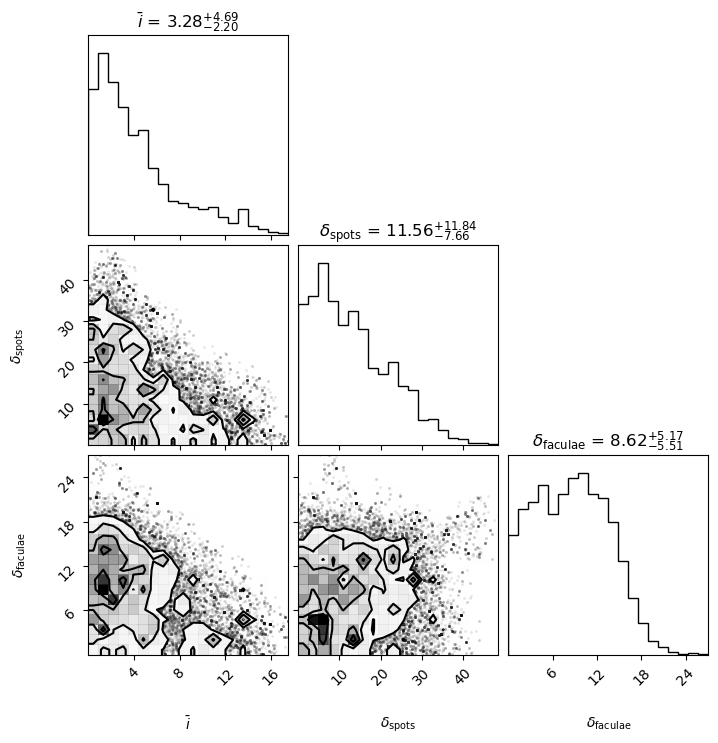

In [12]:
# Corner plot of selected parameters
sel_corner = {
  'cov.fenrir.bar_i': r'$\bar{i}$',
  'cov.fenrir.spots_delta': r'$\delta_\mathrm{spots}$',
  'cov.fenrir.faculae_delta': r'$\delta_\mathrm{faculae}$',
}
kcorner = [model.fit_param.index(key) for key in sel_corner]

subsamp_corner = samples[nsamples // 2 : :, kcorner]

corner(
  subsamp_corner * 180 / np.pi,
  show_titles=True,
  labels=list(sel_corner.values()),
  hist_kwargs=dict(density=1),
)
plt.show()

The corner plot shows that we can constrain the stellar inclination, average latitude of spots and average latitudes of faculae. This comes with caveats, since the inclination of the Sun, of 7.25 degrees with respect to the ecliptic, has a varying projection on the sky plane as the Earth orbits. Despite the many simplifying assumptions made, the average latitude of spots and faculae has a reasonable value: +/- 10 degrees from the solar equator. 

These results do not guarantee that the model used here can robustly give an estimate of the magnetic region properties on other stars, but motivates further analysis of FENRIR models. 

## GP prediction

The GP model yields a predictive distribution of the process. Below we plot the mean and variance of the predictive distribution corresponding to the hyperparameters in the MCMC chain with the highest posterior probability. 

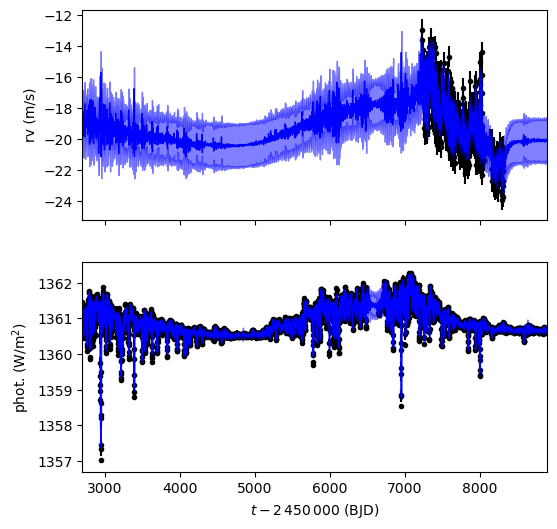

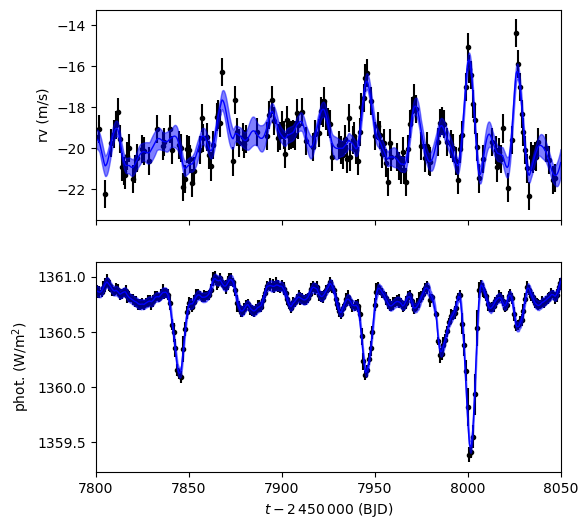

In [13]:
# Plot GP prediction
kbest = np.argmax(diags['logprob'])
model.set_param(samples[kbest])
tslabel = {'rv': 'rv (m/s)', 'phot': 'phot. (W/m$^2$)'}

full_res = model.residuals()
for rgname, tmin, tmax in [
  ('', epoch_rjd + full_t.min(), epoch_rjd + full_t.max()),
  ('_zoom', 57800, 58050),
]:
  tsmooth = np.linspace(tmin, tmax, 2000)
  _, axs = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
  for ks, s in enumerate(series):
    model.cov.kernel['fenrir'].set_conditional_coef(series_id=ks)

    mod, varmod = model.cov.conditional(full_res, tsmooth - epoch_rjd, calc_cov='diag')
    sigmod = np.sqrt(varmod)
    mod += model.get_param(f'lin.{s}_offset')
    ax = axs[ks]
    jit = model.get_param(f'cov.{s}_jit.sig')

    keep = (tmin < ts[ks] + epoch_rjd) & (ts[ks] + epoch_rjd < tmax)
    ax.errorbar(
      ts[ks][keep] + epoch_rjd - 5e4,
      ys[ks][keep],
      np.sqrt(yerrs[ks][keep] ** 2 + jit**2),
      fmt='.',
      color='k',
      rasterized=True,
      zorder=0,
    )

    ax.fill_between(
      tsmooth - 5e4,
      mod - sigmod,
      mod + sigmod,
      color='b',
      alpha=0.5,
      rasterized=True,
      zorder=1,
    )
    ax.plot(tsmooth - 5e4, mod, 'b-', lw=1, rasterized=True, zorder=2)
    ax.set_ylabel(tslabel.get(s, s))

  ax.set_xlabel('$t - 2\\,450\\,000$ (BJD)')
  ax.set_xlim(tmin - 5e4, tmax - 5e4)
  plt.show()